In [1]:
import pandas as pd
import numpy as np

# リスク文データとベクトルを読み込む
df = pd.read_csv("../data/processed/cleaned_risk_dataset.csv")
embeddings = np.load("../data/embeddings/bge_embeddings.npy")

print(df.shape, embeddings.shape)

(2193, 11) (2193, 768)


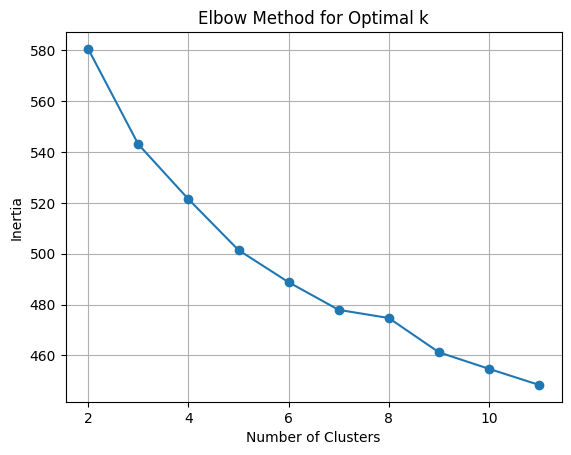

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# エルボー法で最適クラスタ数を探す
inertias = []
k_range = range(2, 12)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(embeddings)
    inertias.append(km.inertia_)

# 可視化
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [4]:
optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto")
df["cluster"] = kmeans.fit_predict(embeddings)

# クラスタごとの文数確認
print(df["cluster"].value_counts())

cluster
0    310
1    310
2    283
8    275
4    263
6    255
7    232
3    188
5     77
Name: count, dtype: int64


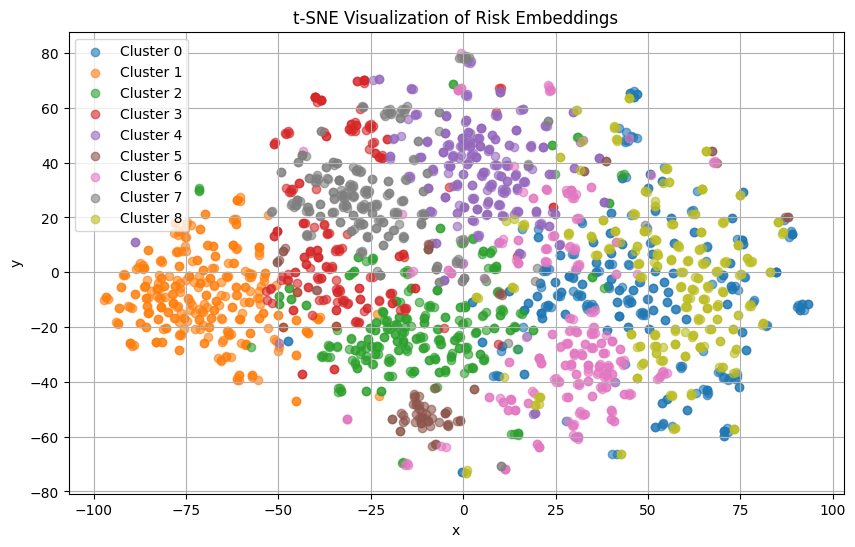

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced = tsne.fit_transform(embeddings)

df["tsne_x"] = reduced[:, 0]
df["tsne_y"] = reduced[:, 1]

# プロット
plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    subset = df[df["cluster"] == i]
    plt.scatter(subset["tsne_x"], subset["tsne_y"], label=f"Cluster {i}", alpha=0.6)
plt.legend()
plt.title("t-SNE Visualization of Risk Embeddings")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [6]:
# 各クラスタの代表文を3つずつ表示（中心に近いもの）
from sklearn.metrics import pairwise_distances_argmin_min

for i in range(optimal_k):
    cluster_embeddings = embeddings[df["cluster"] == i]
    center = kmeans.cluster_centers_[i].reshape(1, -1)
    closest_idx, _ = pairwise_distances_argmin_min(center, cluster_embeddings)
    print(f"\nCluster {i} - Representative Risk Statements:")
    print(df[df["cluster"] == i].iloc[closest_idx[:3]]["token_str"].tolist())


Cluster 0 - Representative Risk Statements:
['２ 事業 リスク 有価証券 報告書 記載 し 事業 状況 経理 状況 関する 事項 うち 経営者 連結 会社 財政 状態 経営 成績 キャッシュ フロー 状況 影響 与える 可能性 認識 し リスク 以下 とおり あり 文中 将来 関する 事項 連結 会計 年度末 現在 おい 当社 グループ 判断 し あり １ 事業 特徴 設備 投資 関連 事業 中心 当社 グループ 事業 国内外 景気 動向 左右 さ 製品 納期 長い 調達 価格 為替 変動 よる 収益性 低下 追加費用 発生 よっ 受注 時 見積もり コスト 増加 する 可能性 あり 当社 グループ 経済 状況 注意 深く 見守り 業績 直結 する 受注 つい 月次 部門 業績 報告 会議 おい 現状 踏まえ 予測 討議 し 状況 応じ 経営 資源 流動化 対応 行っ おり 製品 ライフサイクル 注視 し 中長期的 製品 事業 ポートフォリオ 意識 し 経営 努め おり ２ 設備 減損 係る リスク 当社 グループ 既存 事業 競争力 強化 事業 製品 取り込み 設備 投資 行っ い 固定 資産 減損 係る 会計基準 従い 同 資産 貸借対照表 計上 額 つい 将来 キャッシュ フロー 回収 する できる 定期的 検証 し い キャッシュ フロー 見込め 場合 当社 グループ 業績 財政 状況 影響 受ける 可能性 あり 当社 グループ 設備 投資 計画 対し 取締役会 おい 投資 計画 妥当性 審議 行い 決定 し おり 投資 関し 月次 部門 業績 報告 会議 投資 業績 計画 大きく 乖離 し い 確認 し 必要 応じ 関係 部門 対策 検討 実行 し おり ３ 原材料 部品 調達 当社 グループ 原材料 部品 調達 為替 市況 エネルギー 価格 変動 影響 受け 原材料 部品 品質 問題 供給 不足 納入 遅延 災害 伴う 生産 停止 発生 市況 変動 よる 原材料 部品 調達 価格 高騰 当社 グループ 業績 影響 与える 可能性 あり 当社 グループ 原材料 部品 市況 変動 対応 する 調達 複数 購買 推進 代替 調達 検討 選定 適宜 実施 し 当社 グループ 業績 財政 状況 与える 影響 軽減 す

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# 1. 全文を使ってTF-IDFを計算
all_texts = df["token_str"].dropna().tolist()
vectorizer_all = TfidfVectorizer(max_features=3000)
tfidf_all = vectorizer_all.fit_transform(all_texts)
global_vocab = vectorizer_all.get_feature_names_out()

# 2. 単語ごとのスコア平均を算出
mean_scores_all = tfidf_all.mean(axis=0).A1

# 3. 上位 N個の「共通語」を取得（除外候補）
top_common = list(set(global_vocab[mean_scores_all.argsort()[::-1][:50]]))

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = top_common
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words)

for cluster_id in sorted(df["cluster"].unique()):
    texts = df[df["cluster"] == cluster_id]["token_str"].dropna().tolist()
    
    if not texts:
        continue

    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    mean_scores = tfidf_matrix.mean(axis=0).A1
    top_n = 10
    top_idx = mean_scores.argsort()[::-1][:top_n]

    print(f"\nクラスタ {cluster_id} の特徴語 Top {top_n}:")
    for i in top_idx:
        print(f"  {feature_names[i]}: {mean_scores[i]:.3f}")


クラスタ 0 の特徴語 Top 10:
  開発: 0.048
  連結: 0.045
  品質: 0.042
  展開: 0.042
  金利: 0.041
  技術: 0.040
  需要: 0.040
  経済: 0.040
  商品: 0.040
  システム: 0.039

クラスタ 1 の特徴語 Top 10:
  対策: 0.072
  体制: 0.068
  実施: 0.067
  強化: 0.056
  技術: 0.054
  とも: 0.052
  リスク管理: 0.051
  努め: 0.051
  品質: 0.050
  推進: 0.050

クラスタ 2 の特徴語 Top 10:
  努め: 0.055
  実施: 0.053
  強化: 0.051
  体制: 0.051
  対策: 0.048
  とも: 0.046
  確保: 0.044
  技術: 0.043
  品質: 0.043
  関連: 0.041

クラスタ 3 の特徴語 Top 10:
  実施: 0.057
  対策: 0.056
  野村: 0.051
  低下: 0.049
  努め: 0.048
  強化: 0.047
  関連: 0.046
  体制: 0.046
  商品: 0.045
  経済: 0.045

クラスタ 4 の特徴語 Top 10:
  商品: 0.053
  展開: 0.046
  システム: 0.042
  低下: 0.042
  開発: 0.041
  訴訟: 0.041
  連結: 0.040
  信用: 0.039
  将来: 0.039
  企業: 0.039

クラスタ 5 の特徴語 Top 10:
  拡大: 0.055
  対策: 0.055
  技術: 0.054
  実施: 0.048
  体制: 0.045
  感染: 0.044
  企業: 0.043
  経済: 0.043
  連結: 0.041
  よっ: 0.041

クラスタ 6 の特徴語 Top 10:
  事項: 0.056
  技術: 0.048
  展開: 0.046
  よっ: 0.044
  受け: 0.044
  商品: 0.039
  医薬品: 0.039
  判断: 0.038
  知的財産権: 0.038
  設備: 0.038

ク

In [9]:
# 業種情報を追加
import pandas as pd
df2 = pd.read_csv('data/processed/nikkei225_complete.csv')
df_complete = pd.merge(df.copy(), df2[['ＥＤＩＮＥＴコード', '提出者業種']], left_on='edinet_code', right_on='ＥＤＩＮＥＴコード', how='left')
df_complete = df_complete.rename(columns={'提出者業種': 'industry'})

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib  # すでに入ってる場合はスキップ

# 1. 全体の業種比率（期待値）
industry_total_ratio = df_complete["industry"].value_counts(normalize=True)

# 2. クラスタ × 業種 の出現頻度
cluster_industry = df_complete.groupby(["cluster", "industry"]).size().unstack(fill_value=0)

# 3. 各クラスタ内の業種比率
cluster_industry_ratio = cluster_industry.div(cluster_industry.sum(axis=1), axis=0)

# 4. 補正比率（観測 / 期待）
corrected_ratio = cluster_industry_ratio.copy()
for col in corrected_ratio.columns:
    corrected_ratio[col] = corrected_ratio[col] / industry_total_ratio[col]

# 5. ヒートマップ表示（1.0が平均、濃いほど過剰）
plt.figure(figsize=(14, 6))
sns.heatmap(corrected_ratio, annot=True, cmap="RdBu_r", center=1.0, fmt=".2f")
plt.title("クラスタごとの業種構成比（全体比に対する相対値）")
plt.xlabel("業種")
plt.ylabel("クラスタ")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

NameError: name 'df_complete' is not defined

## クラスタごとの代表リスク文の要約

In [11]:
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

# クラスタごとの代表文（中心に近いベクトル）
representative_texts = {}

for cluster_id in sorted(df_complete["cluster"].unique()):
    subset = df_complete[df_complete["cluster"] == cluster_id]
    cluster_embeddings = embeddings[subset.index]
    center = cluster_embeddings.mean(axis=0).reshape(1, -1)

    # 中心に最も近いN件を取得（ここでは3件）
    closest_indices, _ = pairwise_distances_argmin_min(center, cluster_embeddings)
    top_texts = subset.iloc[closest_indices[:3]]["token_str"].tolist()

    representative_texts[cluster_id] = top_texts

In [21]:
from langchain_community.llms.llamacpp import LlamaCpp

model_path = "models/Llama-3-ELYZA-JP-8B-q4_k_m.gguf"

llm = LlamaCpp(
    model_path=model_path,
    n_ctx=8192,
    temperature=0.0,
    max_tokens=512,
    verbose=False
)

llama_new_context_with_model: n_batch is less than GGML_KQ_MASK_PAD - increasing to 32


In [23]:
for cluster_id, texts in representative_texts.items():
    prompt = (
           "以下のリスク記述は、意味的に似た文です。\n"
           "これらの共通点を踏まえて、リスクの種類や特徴を簡潔に要約してください。\n\n"
           + "\n\n".join(texts[:2])
    )
    print(f"\n【クラスタ {cluster_id}】要約中...")
    response = llm.predict(prompt)
    print(f"要約: {response}")


【クラスタ 0】要約中...
要約:  はのを がで か は は のカの当の事の各一の は のア あり 受 マ 

  のの出 メの のの  認の ののカ エの の  の のを   が の は ので ののの当 の事の一のの のコのアの 受の受の受の の 受のあり っ のマ   メ 認カス 受か  受の 受受受受受受受受 受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受受マ受受受受受受受受受 受受受の受は受受受受受の受受受の受受の受のカン受受受受ん マス レ 部のカ 一メてん ありん受の認 う か 受受マッ マっ付のカリー の事のカ
カ のカ け の当るはカ カ のののの  の の マス レ  ン   メ     一のパ マ マ マ  受大マ カ マのマ マ マ マッ カ マ マ マ マ マ 事 け マ 付   は   大 大ス 大 メ 大大の大 大大大大大大大大大大大大受大大大大大大大大大大大大大大大大大大 マカ 大大受大事受受受受受大受大大大受大受大大受大受大大大マ 大受大大大大の大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大マ大メ 大受の大大大大大 大け大大事大大

【クラスタ 1】要約中...


ValueError: Requested tokens (17812) exceed context window of 8192

In [ ]:
for cluster_id, texts in representative_texts.items():
    prompt = "以下は企業のリスク記述です。共通点を要約してください。\n\n" + "\n\n".join(texts)
    response = query_engine.query(prompt)
    print(f"\nクラスタ {cluster_id} の要約：\n{response}")

In [ ]:
from src.analysis.return_utils import batch_calculate_returns

# ticker リスト（例：merged_df から）
tickers = merged_df["ticker"].tolist()

# 2022年6月 → 2023年6月 のリターンを計算
returns_df = batch_calculate_returns(
    tickers=tickers,
    price_dir="data/stock_prices",
    year_start=2022
)

# merged_df にマージ
merged_df = merged_df.merge(returns_df, on="ticker", how="left")
